# Setup and Data Loading

In [1]:
!pip install fastf1 pandas matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.6/148.6 kB 3.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.8/164.8 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 48.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.7/70.7 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.6/67.6 kB 3.5 MB/s eta 0:00:00
  Attempting uninstall: websockets
    Found existing installation: websockets 15.0.1
    Uninstalling websockets-15.0.1:
      Successfully uninstalled websockets-15.0.1
  Attempting uninstall: attrs
    Found existing installation: attrs 25.3.0
    Uninstalling attrs-25.3.0:
      Successfully uninstalled attrs-25.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12

In [2]:
import fastf1 as ff1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.linear_model import LogisticRegression # Example model import
from sklearn.preprocessing import StandardScaler  # for feature scaling

YEAR_CURRENT = 2025
EVENT_NAME = 'Mexico'
YEARS_HISTORICAL = [2024, 2023, 2022, 2021, 2020] # let's use a driver dominance factor from the past 5 years
CACHE_DIR = 'cache'
os.makedirs(CACHE_DIR, exist_ok=True)
ff1.Cache.enable_cache(CACHE_DIR)
print(f"FastF1 cache enabled at: {CACHE_DIR}") #we created the cache directory here

#let's use this weekend's FP2 as well as Quali data as well for better prediction
print(f"Loading {YEAR_CURRENT} {EVENT_NAME} GP data...")
try:
    quali_session = ff1.get_session(YEAR_CURRENT, EVENT_NAME, 'Q')
    quali_session.load(laps=True, telemetry=False, weather=False, messages=False) # Loading laps for grid pos
    print(f"-> Qualifying session loaded.")

    fp2_session = ff1.get_session(YEAR_CURRENT, EVENT_NAME, 'FP2')
    fp2_session.load(laps=True, telemetry=False, weather=False, messages=False) # Loading laps needed for pace/deg
    print(f"-> FP2 session loaded.")
    # We will store the laps dataframes for easier access further
    quali_laps = quali_session.laps
    fp2_laps = fp2_session.laps

except Exception as e:
    print(f"Error loading {YEAR_CURRENT} data: {e}. Please ensure data is available.")
    quali_laps = None
    fp2_laps = None
    quali_session = None
    fp2_session = None

# We will use the historical race data for dominance factor
print(f"\nLoading historical {EVENT_NAME} GP race data...")
historical_results = {}
for year in YEARS_HISTORICAL:
    try:
        # The event might be called 'Mexico City' in some years
        event_name_hist = 'Mexico City' if year >= 2021 else 'Mexico'

        # Skip 2020 specifically as the Mexico GP was cancelled that year
        if year == 2020:
             print(f"-> Skipping {year} (No Mexico/Mexico City GP held).")
             historical_results[year] = None
             continue # Move to the next year in the loop

        race_session = ff1.get_session(year, event_name_hist, 'R')
        race_session.load(laps=False, telemetry=False, weather=False, messages=False) #We'll only take the results from the historical events
        historical_results[year] = race_session.results
        print(f"-> {year} {event_name_hist} Race results loaded.")
    except ff1.ergast.ErgastMissingDataError:
         # we handle data missing for 2020 Covid year
         print(f"-> Data not found for {year} {event_name_hist} GP on Ergast. Skipping.")
         historical_results[year] = None
    except Exception as e:
        print(f"Error loading {year} race data: {e}. Skipping this year for historical analysis.")
        historical_results[year] = None 

print("\nData Loading Completed")

# Let's visualise the data for further understanding
if quali_session:
    print(f"\n{YEAR_CURRENT} Qualifying Session Info:")
    print(f"  Name: {quali_session.event['EventName']}")
    print(f"  Date: {quali_session.date.strftime('%Y-%m-%d')}")
    print(f"  Number of laps data: {len(quali_laps) if quali_laps is not None else 'Error'}")

if fp2_session:
    print(f"\n{YEAR_CURRENT} FP2 Session Info:")
    print(f"  Name: {fp2_session.event['EventName']}")
    print(f"  Date: {fp2_session.date.strftime('%Y-%m-%d')}")
    print(f"  Number of laps data: {len(fp2_laps) if fp2_laps is not None else 'Error'}")

print("\nHistorical Data Loaded For Years:")
for year, results_df in historical_results.items():
    status = "Successfully" if results_df is not None else ("Skipped (No Race)" if year == 2020 else "Failed/Not Found")
    print(f"  {year}: {status}")

FastF1 cache enabled at: cache
Loading 2025 Mexico GP data...


core           INFO 	Loading data for Mexico City Grand Prix - Qualifying [v3.6.1]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
req            I

-> Qualifying session loaded.


req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for timing_app_dat

-> FP2 session loaded.

Loading historical Mexico GP race data...


req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
core           INFO 	Finished loading data for 20 drivers: ['55', '4', '16', '44', '63', '1', '20', '81', '27', '10', '18', '43', '31', '77', '24', '30', '11', '14', '23', '22']


-> 2024 Mexico City Race results loaded.


core           INFO 	Loading data for Mexico City Grand Prix - Race [v3.6.1]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
core           INFO 	Finished loading data for 20 drivers: ['1', '44', '16', '55', '4', '63', '3', '81', '23', '31', '10', '22', '27', '24', '77', '2', '18', '14', '20', '11']
core           INFO 	Loading data for Mexico City Grand Prix - Race [v3.6.1]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...


-> 2023 Mexico City Race results loaded.


req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
core           INFO 	Finished loading data for 20 drivers: ['1', '44', '11', '63', '55', '16', '3', '31', '4', '77', '10', '23', '24', '5', '18', '47', '20', '6', '14', '22']
core           INFO 	Loading data for Mexico City Grand Prix - Race [v3.6.1]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...


-> 2022 Mexico City Race results loaded.


req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
core           INFO 	Finished loading data for 20 drivers: ['33', '44', '11', '10', '16', '55', '5', '7', '14', '4', '99', '3', '31', '18', '77', '63', '6', '9', '47', '22']


-> 2021 Mexico City Race results loaded.
-> Skipping 2020 (No Mexico/Mexico City GP held).

Data Loading Completed

2025 Qualifying Session Info:
  Name: Mexico City Grand Prix
  Date: 2025-10-25
  Number of laps data: 307

2025 FP2 Session Info:
  Name: Mexico City Grand Prix
  Date: 2025-10-24
  Number of laps data: 620

Historical Data Loaded For Years:
  2024: Successfully
  2023: Successfully
  2022: Successfully
  2021: Successfully
  2020: Skipped (No Race)


# Qualifying Analysis

## Finding top 10

Qualifying Grid Positions (Abbreviation: Position):
Abbreviation
NOR     1
LEC     2
HAM     3
RUS     4
VER     5
ANT     6
SAI     7
PIA     8
HAD     9
BEA    10
TSU    11
OCO    12
HUL    13
ALO    14
LAW    15
BOR    16
ALB    17
GAS    18
STR    19
COL    20
Name: Position, dtype: int64

Generating Top 10 Grid visualization...
-> Top 10 Grid plot saved as 'mexico_gp_2025_top10_grid.png'


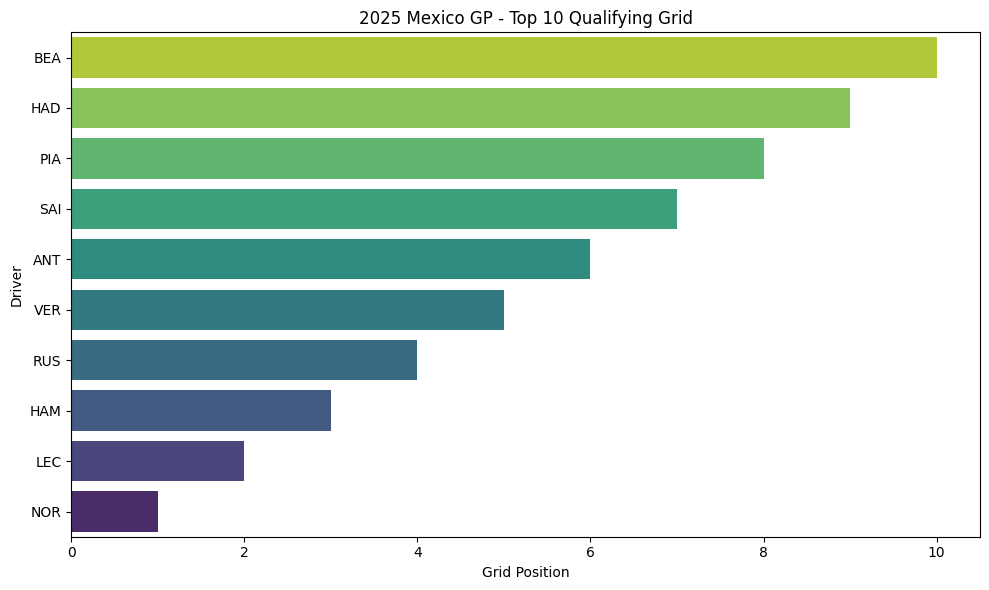


Qualifying Analysis Completed


In [3]:
if quali_session is not None and hasattr(quali_session, 'results') and quali_session.results is not None:
    quali_results_df = quali_session.results #We recheck the loaded quali data


    quali_results_df['Position'] = pd.to_numeric(quali_results_df['Position'], errors='coerce') #We changed the positions to numeric for further analysing
    # We will drop the rows where 'Position' became NaN 
    quali_results_df = quali_results_df.dropna(subset=['Position'])
    quali_results_df['Position'] = quali_results_df['Position'].astype(int)

    grid_positions = quali_results_df[['Abbreviation', 'Position']].sort_values(by='Position').set_index('Abbreviation')['Position'] #We have derived all the Grid data here along with Driver Name Abbreviations for using as Index

    print("Qualifying Grid Positions (Abbreviation: Position):")
    print(grid_positions)

    print("\nGenerating Top 10 Grid visualization...")
    plt.figure(figsize=(10, 6)) #Let's see which drivers are on the points ?
    top_10_grid = grid_positions.head(10)

    sns.barplot(x=top_10_grid.values, y=top_10_grid.index, palette='viridis', orient='h')

    plt.title(f'{YEAR_CURRENT} {EVENT_NAME} GP - Top 10 Qualifying Grid') 
    plt.xlabel('Grid Position') #x-axis
    plt.ylabel('Driver') #y-axis
    plt.gca().invert_yaxis() 
    plt.tight_layout() 
    plt.savefig('mexico_gp_2025_top10_grid.png') #Saving the visualisation for Later use
    print("-> Top 10 Grid plot saved as 'mexico_gp_2025_top10_grid.png'")
    plt.show()

else:
    # Handle the case where qualifying data wasn't loaded successfully
    print("Qualifying results data is not available. Cannot determine grid positions.")
    grid_positions = pd.Series(dtype=int) # Assign an empty Series if data missing

print("\nQualifying Analysis Completed")

## Taking Grid Penalties into account

Confirmed Penalties Applied:
  - SAI: +5 places

 Adjusted Grid Positions (After Confirmed Penalties):
Abbreviation
NOR     1
LEC     2
HAM     3
RUS     4
VER     5
ANT     6
PIA     7
HAD     8
BEA     9
TSU    10
OCO    11
SAI    12
HUL    13
ALO    14
LAW    15
BOR    16
ALB    17
GAS    18
STR    19
COL    20
Name: AdjustedPosition, dtype: int64

Generating Adjusted Top 10 Grid visualization...
-> Adjusted Top 10 Grid plot saved as 'mexico_gp_2025_top10_adjusted_grid_confirmed.png'


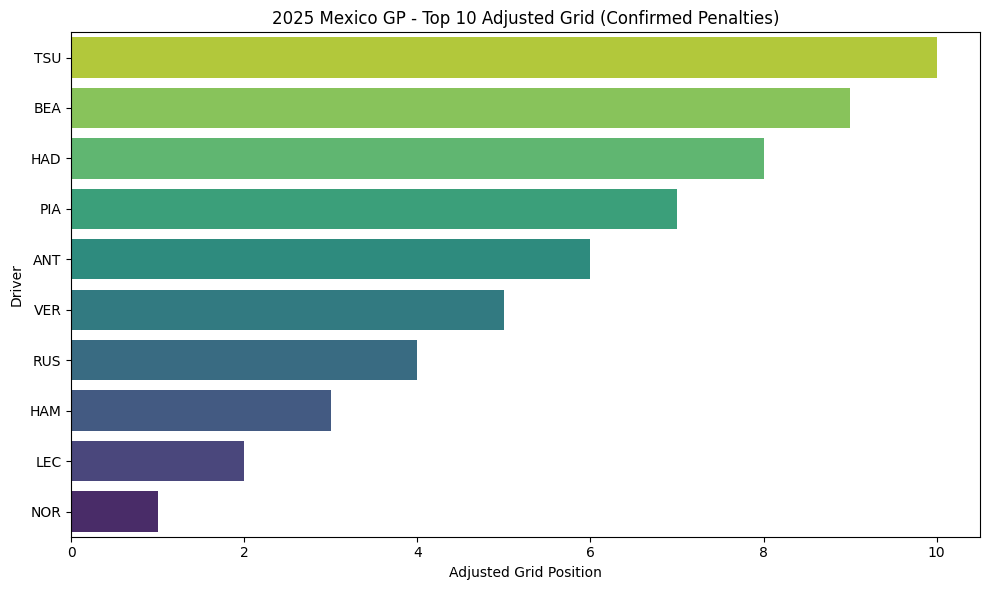


Grid Penalty Application Completed


In [6]:
if grid_positions is not None and not grid_positions.empty:
    # --- Confirmed Penalties --
    penalties = {
        'SAI': 5  # Confirmed: Sainz gets a 5-place grid penalty
    }
    print("Confirmed Penalties Applied:")
    for driver, places in penalties.items():
        print(f"  - {driver}: +{places} places")

    adjusted_grid = grid_positions.copy()

    # We have to apply the penalties
    drivers_with_penalties = list(penalties.keys())

    # initial positions with quali ranks
    initial_positions = {driver: i + 1 for i, driver in enumerate(grid_positions.index)}

    # now, the penalized positions
    penalized_positions = {}
    for driver in initial_positions:
        penalty = penalties.get(driver, -1)
        penalized_positions[driver] = initial_positions[driver] + penalty

    
    sorted_drivers = sorted(
        initial_positions.keys(),
        key=lambda d: (penalized_positions[d], initial_positions[d])
    )

    # We can now find the final grid posiions
    final_grid_positions = pd.Series({driver: i + 1 for i, driver in enumerate(sorted_drivers)}, name="AdjustedPosition")
    final_grid_positions.index.name = 'Abbreviation'


    print("\n Adjusted Grid Positions (After Confirmed Penalties):")
    print(final_grid_positions)

    # Let's see the top 10 now ?
    print("\nGenerating Adjusted Top 10 Grid visualization...")
    plt.figure(figsize=(10, 6))
    top_10_adjusted = final_grid_positions.head(10)
    sns.barplot(x=top_10_adjusted.values, y=top_10_adjusted.index, palette='viridis', orient='h')
    plt.title(f'{YEAR_CURRENT} {EVENT_NAME} GP - Top 10 Adjusted Grid (Confirmed Penalties)')
    plt.xlabel('Adjusted Grid Position')
    plt.ylabel('Driver')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig('mexico_gp_2025_top10_adjusted_grid_confirmed.png')
    print("-> Adjusted Top 10 Grid plot saved as 'mexico_gp_2025_top10_adjusted_grid_confirmed.png'")
    plt.show()

else:
    print("Original grid positions not available. Cannot apply penalties.")
    final_grid_positions = None

print("\nGrid Penalty Application Completed")

#Let's update the main model for later as well
feature_grid_positions = final_grid_positions if final_grid_positions is not None else grid_positions

# Long-Run Pace Analysis
- We will extract the true race pace from the FP2 data

Analyzing long run pace on MEDIUM tyres for top drivers: NOR, LEC, HAM, RUS, VER, ANT, PIA, HAD
  -> Found MEDIUM Stint 5.0 for LEC: Avg Pace=83.395s, Laps=13
  -> Found MEDIUM Stint 1.0 for HAM: Avg Pace=79.816s, Laps=3
  -> Found MEDIUM Stint 4.0 for HAM: Avg Pace=83.151s, Laps=7
  -> Found MEDIUM Stint 5.0 for RUS: Avg Pace=83.083s, Laps=9
  -> Found MEDIUM Stint 5.0 for VER: Avg Pace=83.088s, Laps=11
  -> Found MEDIUM Stint 4.0 for ANT: Avg Pace=82.738s, Laps=11

Average Long Run Pace per Driver (s):
Abbreviation
HAM    81.483476
ANT    82.738364
RUS    83.083222
VER    83.087545
LEC    83.394615
Name: AvgLongRunPace, dtype: float64

Generating Long Run Pace Boxplot visualization:


/usr/local/lib/python3.11/dist-packages/fastf1/plotting/_plotting.py:57: FutureWarning: The `misc_mpl_mods` argument was dropped from `.setup_mpl()` in version 3.6.0 and has no effect anymore. It will be removed in a future version of FastF1.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/fastf1/core.py:3183: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/usr/local/lib/python3.11/dist-packages/fastf1/core.py:3183: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/usr/local/lib/python3.11/dist-packages/fastf1/core.py:3183: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/usr/local/lib/python3.11/dist-package

-> Long Run Pace Boxplot saved as 'mexico_gp_2025_fp2_long_run_pace.png'

Long Run Pace Analysis Completed


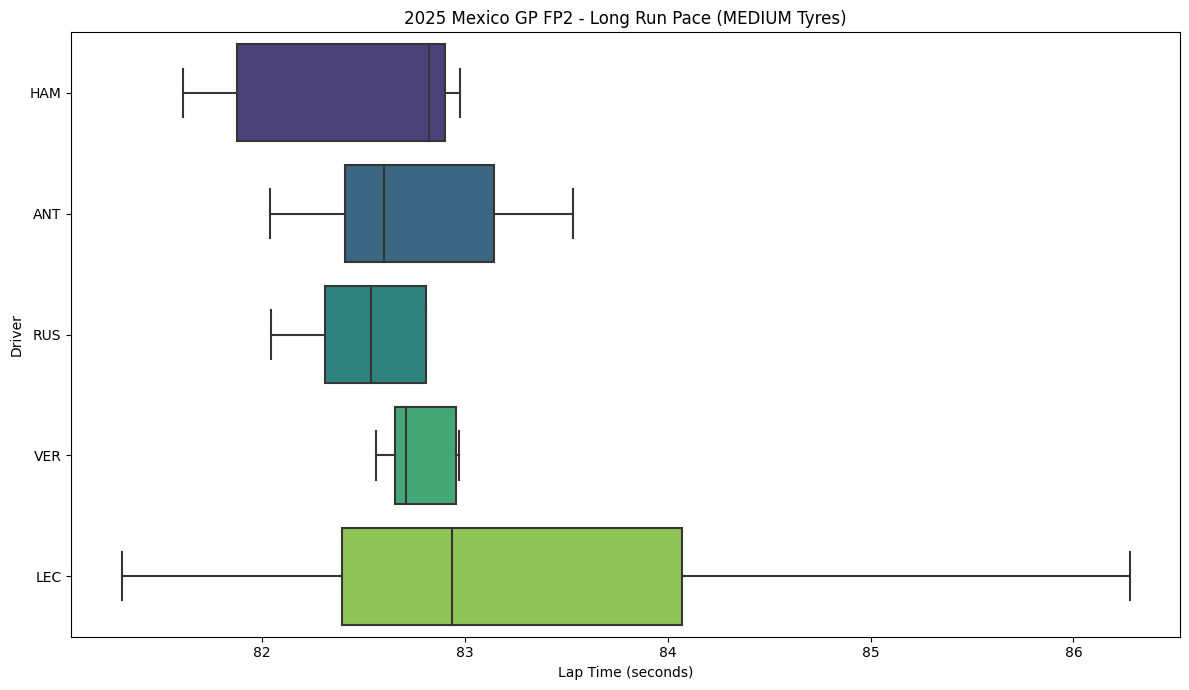

In [17]:
import fastf1.plotting
import fastf1.utils
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np 

if fp2_laps is not None and not fp2_laps.empty:
    RACE_COMPOUND = 'MEDIUM' #tyre type
    # We will find the minimum laps for a stint to be considered a 'long run'
    MIN_STINT_LENGTH = 10 #I'll take the minimum stint length to be 10 laps 
    N_DRIVERS_PACE = 8 #Let's analyse top 8 driver's pace
   
    if 'feature_grid_positions' in globals() and feature_grid_positions is not None and not feature_grid_positions.empty:
         top_drivers_abbr = feature_grid_positions.sort_values().head(N_DRIVERS_PACE).index.tolist()
    else:
         print("Grid positions not available, analyzing first few drivers found in FP2 laps as fallback.")
         # Fallback: We will try to get first N unique drivers from FP2 laps if grid is missing
         top_drivers_abbr = fp2_laps['Abbreviation'].unique()[:N_DRIVERS_PACE].tolist()


    print(f"Analyzing long run pace on {RACE_COMPOUND} tyres for top drivers: {', '.join(top_drivers_abbr)}")

    
    long_run_data = []
    fastf1.plotting.setup_mpl(misc_mpl_mods=False)

    for driver in top_drivers_abbr:
        # We'll get all laps for the driver in FP2
        driver_laps_fp2 = fp2_laps.pick_driver(driver).reset_index(drop=True)
        stints = driver_laps_fp2.groupby('Stint')

        for stint_num, stint_laps in stints:
            compound = stint_laps['Compound'].iloc[0]
            stint_length = len(stint_laps)

            if compound == RACE_COMPOUND and stint_length >= MIN_STINT_LENGTH:
                quick_laps = stint_laps.pick_quicklaps().copy() 

                if not quick_laps.empty:
                    quick_laps.loc[:, 'LapTimeSeconds'] = quick_laps['LapTime'].dt.total_seconds()

                    # We will calculate the average pace and consistency (standard deviation)
                    avg_pace = quick_laps['LapTimeSeconds'].mean()
                    std_dev_pace = quick_laps['LapTimeSeconds'].std()
                    num_laps_analyzed = len(quick_laps)

                    long_run_data.append({
                        'Abbreviation': driver,
                        'Stint': stint_num,
                        'Compound': compound,
                        'AvgPace': avg_pace,
                        'StdDevPace': std_dev_pace,
                        'NumLaps': num_laps_analyzed,
                        'AllLapTimes': quick_laps['LapTimeSeconds'].tolist() # Store all lap times for boxplot
                    })
                    print(f"  -> Found {RACE_COMPOUND} Stint {stint_num} for {driver}: Avg Pace={avg_pace:.3f}s, Laps={num_laps_analyzed}")

    # Converting results to DataFrame
    long_run_df = pd.DataFrame(long_run_data)

 
    if not long_run_df.empty:
        feature_avg_pace = long_run_df.groupby('Abbreviation')['AvgPace'].mean().rename('AvgLongRunPace')
        print("\nAverage Long Run Pace per Driver (s):")
        print(feature_avg_pace.sort_values()) # Print sorted pace

        # We will make Boxplots for better understanding
        print("\nGenerating Long Run Pace Boxplot visualization:")
        boxplot_data = []
        for index, row in long_run_df.iterrows():
             for lap_time in row['AllLapTimes']:
                 boxplot_data.append({'Abbreviation': row['Abbreviation'], 'LapTimeSeconds': lap_time})
        boxplot_df = pd.DataFrame(boxplot_data)

        plt.figure(figsize=(12, 7))
        order = feature_avg_pace.sort_values().index
        sns.boxplot(data=boxplot_df, x='LapTimeSeconds', y='Abbreviation', order=order, palette='viridis', orient='h', showfliers=False) # Hide outliers for cleaner look
        plt.title(f'{YEAR_CURRENT} {EVENT_NAME} GP FP2 - Long Run Pace ({RACE_COMPOUND} Tyres)')
        plt.xlabel('Lap Time (seconds)')
        plt.ylabel('Driver')
        plt.tight_layout()
        plt.savefig('mexico_gp_2025_fp2_long_run_pace.png')
        print("-> Long Run Pace Boxplot saved as 'mexico_gp_2025_fp2_long_run_pace.png'")
        # plt.show()

    else:
        print(f"\nNo sufficient long runs found on {RACE_COMPOUND} tyres for the selected drivers.")
        feature_avg_pace = pd.Series(dtype=float)

else:
    print("FP2 laps data is not available. Cannot analyze long run pace.")
    feature_avg_pace = pd.Series(dtype=float)

print("\nLong Run Pace Analysis Completed")

# Tyre Degradation Analysis

Calculating tyre degradation from MEDIUM stints
  -> Calculated Degradation for LEC Stint 5: +0.242 s/lap
  -> Calculated Degradation for HAM Stint 1: -0.730 s/lap
  -> Calculated Degradation for HAM Stint 4: +0.232 s/lap
  -> Calculated Degradation for RUS Stint 5: +0.382 s/lap
  -> Calculated Degradation for VER Stint 5: +0.155 s/lap
  -> Calculated Degradation for ANT Stint 4: +0.102 s/lap

Average Tyre Degradation Slope per Driver (s/lap):
Abbreviation
HAM   -0.248982
ANT    0.101776
VER    0.155473
LEC    0.241527
RUS    0.382383
Name: AvgDegradationSlope, dtype: float64

Generating Degradation Trendline visualization for key drivers...


/usr/local/lib/python3.11/dist-packages/fastf1/core.py:3183: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/usr/local/lib/python3.11/dist-packages/fastf1/plotting/_plotting.py:57: FutureWarning: The `misc_mpl_mods` argument was dropped from `.setup_mpl()` in version 3.6.0 and has no effect anymore. It will be removed in a future version of FastF1.
  warnings.warn(


-> Degradation Trendline plot saved as 'mexico_gp_2025_fp2_degradation_trends.png'

Tyre Degradation Analysis Completed


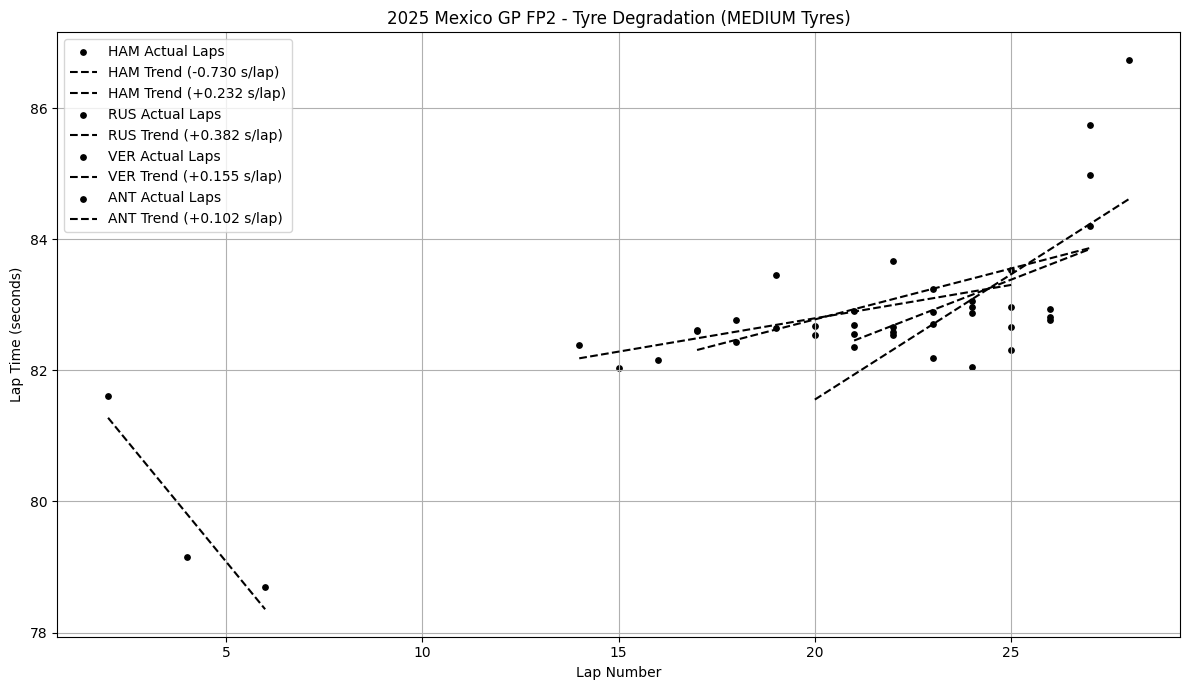

In [18]:
import fastf1.plotting
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

if 'long_run_df' in globals() and not long_run_df.empty:
    print(f"Calculating tyre degradation from {RACE_COMPOUND} stints")

    degradation_results = []
    analyzed_stints_for_plot = {}

    for index, stint_info in long_run_df.iterrows():
        driver = stint_info['Abbreviation']
        stint_num = stint_info['Stint']

        driver_laps_fp2 = fp2_laps.pick_driver(driver).reset_index(drop=True)
        stint_laps_full = driver_laps_fp2[driver_laps_fp2['Stint'] == stint_num] #Isolating the laps belonging to the specific stint
        quick_laps_stint = stint_laps_full.pick_quicklaps().copy() #We will remove in-out laps

        if len(quick_laps_stint) > 2:
            lap_numbers = quick_laps_stint['LapNumber']
            lap_times_sec = quick_laps_stint['LapTime'].dt.total_seconds()

            try:
                coeffs = np.polyfit(lap_numbers, lap_times_sec, 1) # polyfit returns [slope, intercept]
                degradation_slope = coeffs[0]

                # We will store the degradation results
                degradation_results.append({
                    'Abbreviation': driver,
                    'Stint': stint_num,
                    'DegradationSlope': degradation_slope,
                    'NumLaps': len(quick_laps_stint)
                })

                # Corrected color fetching using team color
                driver_abbr = driver
                try:
                    team_name = fp2_session.get_driver(driver_abbr)['TeamName']
                    team_color_hex = fastf1.plotting.team_color(team_name)
                    driver_plot_color = f"#{team_color_hex}" if team_color_hex else 'grey'
                except Exception:
                    driver_plot_color = 'black'

                analyzed_stints_for_plot[f"{driver}_S{int(stint_num)}"] = {
                    'LapNumbers': lap_numbers.tolist(),
                    'LapTimes': lap_times_sec.tolist(),
                    'Slope': degradation_slope,
                    'Intercept': coeffs[1],
                    'Driver': driver,
                    'Color': driver_plot_color
                 }
                print(f"  -> Calculated Degradation for {driver} Stint {int(stint_num)}: {degradation_slope:+.3f} s/lap")

            except np.linalg.LinAlgError:
                 print(f"  -> Could not calculate degradation for {driver} Stint {int(stint_num)} due to calculation error.")
            except Exception as e:
                 print(f"  -> Error calculating degradation for {driver} Stint {int(stint_num)}: {e}")
        else:
            print(f"  -> Not enough quick laps ({len(quick_laps_stint)}) for {driver} Stint {int(stint_num)} to calculate degradation.")

    degradation_df = pd.DataFrame(degradation_results)

    # We will store verage degradation of model
    if not degradation_df.empty:
        feature_tyre_deg = degradation_df.groupby('Abbreviation')['DegradationSlope'].mean().rename('AvgDegradationSlope')
        print("\nAverage Tyre Degradation Slope per Driver (s/lap):")
        print(feature_tyre_deg.sort_values())

        print("\nGenerating Degradation Trendline visualization for key drivers...")
        if 'feature_avg_pace' in globals() and not feature_avg_pace.empty:
            drivers_to_plot = feature_avg_pace.sort_values().head(4).index.tolist()
        else:
            drivers_to_plot = degradation_df['Abbreviation'].unique()[:4].tolist()

        # We will now visualize them
        plt.figure(figsize=(12, 7))
        fastf1.plotting.setup_mpl(misc_mpl_mods=False)

        for key, stint_data in analyzed_stints_for_plot.items():
            driver_abbr = stint_data['Driver']
            if driver_abbr in drivers_to_plot:
                lap_nums = np.array(stint_data['LapNumbers'])
                lap_times = np.array(stint_data['LapTimes'])
                slope = stint_data['Slope']
                intercept = stint_data['Intercept']
                color = stint_data['Color']

                plt.scatter(lap_nums, lap_times, color=color, label=f'{driver_abbr} Actual Laps', s=15)
                trend_line = intercept + slope * lap_nums
                plt.plot(lap_nums, trend_line, color=color, linestyle='--', label=f'{driver_abbr} Trend ({slope:+.3f} s/lap)')

        plt.title(f'{YEAR_CURRENT} {EVENT_NAME} GP FP2 - Tyre Degradation ({RACE_COMPOUND} Tyres)')
        plt.xlabel('Lap Number')
        plt.ylabel('Lap Time (seconds)')
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys())
        plt.grid(True)
        plt.tight_layout()
        plt.savefig('mexico_gp_2025_fp2_degradation_trends.png')
        print("-> Degradation Trendline plot saved as 'mexico_gp_2025_fp2_degradation_trends.png'")
        # plt.show()

    else:
        print("\nNo degradation data calculated.")
        feature_tyre_deg = pd.Series(dtype=float)

else:
    print("Long run data from Block 3 is not available. Cannot analyze degradation.")
    feature_tyre_deg = pd.Series(dtype=float)

print("\nTyre Degradation Analysis Completed")

# Feature Engineering and Model Prediction

In [19]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import numpy as np 

# We will finally calculate the dominance factor
print("Calculating dominance factor (Average Historical Finish)...")
driver_avg_finish = {}

if 'feature_grid_positions' in globals() and feature_grid_positions is not None:
    current_drivers = feature_grid_positions.index.tolist()
else:
    print("Warning: Grid positions not found. Cannot accurately determine current drivers for historical analysis.")
    # Fallback: We will use the drivers from FP2 pace analysis, or load driver list separately if needed
    current_drivers = feature_avg_pace.index.tolist() if 'feature_avg_pace' in globals() and feature_avg_pace is not None else []


if current_drivers:
    for driver in current_drivers:
        finishes = []
        years_counted = 0
        for year in YEARS_HISTORICAL:
            if historical_results.get(year) is not None:
                # With this, we will find the driver's results for that year
                driver_result = historical_results[year][historical_results[year]['Abbreviation'] == driver]
                if not driver_result.empty:
                    # We will also ensure that the 'Position' is numeric, coerce errors for DNF/DNS etc.
                    pos = pd.to_numeric(driver_result['Position'].iloc[0], errors='coerce')
                    if pd.notna(pos): # Only count actual numeric finishes
                        finishes.append(pos)
                        years_counted += 1

        # We'll find the avaerage finish
        if finishes:
            avg_finish = np.mean(finishes)
            driver_avg_finish[driver] = avg_finish
            print(f"  -> {driver}: Avg Finish = {avg_finish:.2f} (over {years_counted} year(s))")
        else:
            
            driver_avg_finish[driver] = len(current_drivers) + 1
            print(f"  -> {driver}: No valid historical finishes found, assigning default.")

    feature_dominance = pd.Series(driver_avg_finish, name='AvgHistFinish')
else:
    print("No current drivers identified. Cannot calculate dominance factor.")
    feature_dominance = pd.Series(dtype=float)


# We will now combine all the features
print("\nCombining features into a single DataFrame")
# We'll with the grid positions (most reliable feature)
if 'feature_grid_positions' in globals() and feature_grid_positions is not None:
    features_df = feature_grid_positions.to_frame(name='QualiPosition')

    # We'll add the other calculated features
    if 'feature_avg_pace' in globals() and feature_avg_pace is not None:
        features_df = features_df.join(feature_avg_pace)
    if 'feature_tyre_deg' in globals() and feature_tyre_deg is not None:
        features_df = features_df.join(feature_tyre_deg)
    if feature_dominance is not None:
         features_df = features_df.join(feature_dominance)

    #Let's handle a bit of missing data
    if 'AvgLongRunPace' in features_df:
        median_pace = features_df['AvgLongRunPace'].median()
        features_df['AvgLongRunPace'].fillna(median_pace, inplace=True)
        print(f"Filled missing AvgLongRunPace with median: {median_pace:.3f}s")

    if 'AvgDegradationSlope' in features_df:
        median_deg = features_df['AvgDegradationSlope'].median()
        # Handle the unusual negative HAM value 
        features_df['AvgDegradationSlope'].fillna(median_deg, inplace=True)
        print(f"Filled missing AvgDegradationSlope with median: {median_deg:+.3f} s/lap")
        

    if 'AvgHistFinish' in features_df: #already calculated
         pass

    # We'll drop any rows that *still* have NaN values (e.g., if QualiPosition was missing initially)
    features_df.dropna(inplace=True)

    print("\nFinal Features DataFrame (Top Rows):")
    print(features_df.head(N_DRIVERS_PACE)) # Show features for analyzed drivers

    
    # Simulating prediction
    print("\nSimulating model prediction (using simple weights)...")
    weights = {'QualiPosition': -0.45, 'AvgLongRunPace': -0.25, 'AvgDegradationSlope': -0.15, 'AvgHistFinish': -0.05}

    # We will calculate a score 
    score = (features_df['QualiPosition'] * weights['QualiPosition'] +
             features_df['AvgLongRunPace'] * weights['AvgLongRunPace'] +
             features_df['AvgDegradationSlope'] * weights['AvgDegradationSlope'] +
             features_df['AvgHistFinish'] * weights['AvgHistFinish'])

    # Converting score to pseudo-probabilities 
    exp_score = np.exp(score - np.max(score)) # Subtract max for numerical stability
    probabilities = exp_score / exp_score.sum()
    probabilities = probabilities.rename('WinProbability').sort_values(ascending=False)

    #Let's print the results

    print("\nPredicted Win Probabilities")
    results_table = features_df.join(probabilities)
    results_table = results_table.sort_values(by='WinProbability', ascending=False)

    results_table['WinProbability'] = results_table['WinProbability'].map('{:.1%}'.format)
    results_table['AvgLongRunPace'] = results_table['AvgLongRunPace'].map('{:.3f}s'.format)
    results_table['AvgDegradationSlope'] = results_table['AvgDegradationSlope'].map('{:+.3f} s/lap'.format)
    results_table['AvgHistFinish'] = results_table['AvgHistFinish'].map('{:.1f}'.format)


    print(results_table[['QualiPosition', 'AvgLongRunPace', 'AvgDegradationSlope', 'AvgHistFinish', 'WinProbability']].head(10)) # Display top 10


else:
    print("Feature dataframes (grid, pace, deg, dominance) are missing or empty. Cannot proceed.")

print("\nModel Prediction Completed")

Calculating dominance factor (Average Historical Finish)...
  -> NOR: Avg Finish = 6.50 (over 4 year(s))
  -> LEC: Avg Finish = 4.25 (over 4 year(s))
  -> HAM: Avg Finish = 2.50 (over 4 year(s))
  -> RUS: Avg Finish = 7.75 (over 4 year(s))
  -> VER: Avg Finish = 2.25 (over 4 year(s))
  -> ANT: No valid historical finishes found, assigning default.
  -> PIA: Avg Finish = 8.00 (over 2 year(s))
  -> HAD: No valid historical finishes found, assigning default.
  -> BEA: No valid historical finishes found, assigning default.
  -> TSU: Avg Finish = 18.00 (over 4 year(s))
  -> OCO: Avg Finish = 11.00 (over 4 year(s))
  -> SAI: Avg Finish = 4.00 (over 4 year(s))
  -> HUL: Avg Finish = 11.00 (over 2 year(s))
  -> ALO: Avg Finish = 16.00 (over 4 year(s))
  -> LAW: Avg Finish = 16.00 (over 1 year(s))
  -> BOR: No valid historical finishes found, assigning default.
  -> ALB: Avg Finish = 13.33 (over 3 year(s))
  -> GAS: Avg Finish = 9.00 (over 4 year(s))
  -> STR: Avg Finish = 14.25 (over 4 year(s)

/tmp/ipykernel_37/1021614712.py:66: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  features_df['AvgLongRunPace'].fillna(median_pace, inplace=True)
/tmp/ipykernel_37/1021614712.py:72: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace